<a href="https://colab.research.google.com/github/niteshctrl/mask_detection/blob/main/Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
pip install -q -U keras-tuner

     |████████████████████████████████| 102kB 4.7MB/s 


In [26]:
# Import Libraries


import os
import cv2
import glob
from google.colab import drive
from google.colab import files
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

import tensorflow as tf
import kerastuner as kt
from tensorflow import keras as K
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model, Sequential
from tensorflow.keras.applications import MobileNetV2, VGG16
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  del sys.path[0]


In [2]:
# Connect Google Drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cd '/content/gdrive/MyDrive/datasets/mask_detection'

/content/gdrive/MyDrive/datasets/mask_detection


In [4]:
pwd

'/content/gdrive/MyDrive/datasets/mask_detection'

In [ ]:
# Download the Data from Kaggle

# Upload Kaggle API Key

files.upload()

# Install Kaggle Library and auth permission

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission


# Data Download from Kaggle

!kaggle datasets download -d 'andrewmvd/face-mask-detection' # -p '/content/gdrive/My Drive/colab/amazon'

Saving kaggle.json to kaggle.json
kaggle.json
100% 398M/398M [00:03<00:00, 115MB/s]



In [ ]:
!unzip face-mask-detection.zip

In [5]:
# A few Global variables

image_size = [224, 224]

anno_dir = 'annotations/'
images_dir = 'images/'
face_crops_dir = 'face_crops/'

In [ ]:
'''The annotations directory has 853 XML files with nomenclature as 
"maksssksksss<_>.xml" where <_> stands for a number ranging from 0 to 852

Similarly for images "maksssksksss<_>.png" for corresponding image file of XML

Since we have 3 classes(with_mask, without_mask and mask_weared_incorrect), 
we will dump the face crops in three different directories after cropping the 
faces.
'''

def dump_face_crops(anno_dir, images_dir, face_crops_dir):

    if not os.path.exists(face_crops_dir+'with_mask'):
        os.makedirs(face_crops_dir+'with_mask')
    if not os.path.exists(face_crops_dir+'without_mask'):
        os.makedirs(face_crops_dir+'without_mask')
    if not os.path.exists(face_crops_dir+'mask_weared_incorrect'):
        os.makedirs(face_crops_dir+'mask_weared_incorrect')

    j = 0
    anno_files_count = len(glob.glob(anno_dir+'*')) # Number of annotation files
    for i in range(anno_files_count):
        tree = ET.parse(anno_dir+'maksssksksss'+str(i)+'.xml') # Parse the XML tree
        root = tree.getroot() # Get the root

        objects = root.findall('object')
        for obj in objects:         # Iterate through all the objects(aka faces)
            name = obj.find('name').text

            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)


            #########################
            # Crop and save the faces
            cropped = cv2.imread(images_dir+'maksssksksss'+str(i)+'.png')
            cropped = cropped[ymin:ymax, xmin:xmax]
            cv2.imwrite(face_crops_dir+name+'/'+str(j)+'.jpg', cropped)
            j = j + 1

In [ ]:
dump_face_crops(anno_dir, images_dir, face_crops_dir)

In [20]:
# Defining the Model function


def build_model():
    classes_count = glob.glob(face_crops_dir+'*')

    base_model = MobileNetV2(weights='imagenet', 
                             include_top=False, 
                             input_shape=(224, 224, 3))

    head_model = base_model.output
    head_model = Flatten()(head_model)
    head_model = Dropout(0.5)(head_model)
    head_model = Dense(128, activation='relu', kernel_initializer="he_normal")(head_model)
    head_model = Dropout(0.5)(head_model)
    head_model = Dense(64, activation='relu', kernel_initializer="he_normal")(head_model)
    head_model = Dropout(0.5)(head_model)
    head_model = Dense(32, activation='relu', kernel_initializer="he_normal")(head_model)
    head_model = Dense(len(classes_count), activation='softmax')(head_model)

    # Place the head model on top of the base model

    model = Model(inputs=base_model.input, outputs=head_model)
    for layer in base_model.layers:
        layer.trainable = False

        
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=['accuracy'], 
                  loss='categorical_crossentropy'
                 )
    
    return model

In [27]:
# Defining the Model function


def model_builder(hp):
    classes_count = glob.glob(face_crops_dir+'*')
    hp_dropout = hp.Choice('dropout', values=[0.1, 0.25, 0.5])

    base_model = MobileNetV2(weights='imagenet', 
                             include_top=False, 
                             input_shape=(224, 224, 3))

    head_model = base_model.output
    head_model = Flatten()(head_model)

    head_model = Dropout(hp_dropout)(head_model)
    head_model = Dense(128, activation='relu', kernel_initializer="he_normal")(head_model)
    
    head_model = Dropout(hp_dropout)(head_model)
    head_model = Dense(64, activation='relu', kernel_initializer="he_normal")(head_model)
    
    head_model = Dropout(hp_dropout)(head_model)
    head_model = Dense(32, activation='relu', kernel_initializer="he_normal")(head_model)
    head_model = Dense(len(classes_count), activation='softmax')(head_model)

    # Place the head model on top of the base model

    model = Model(inputs=base_model.input, outputs=head_model)
    for layer in base_model.layers:
        layer.trainable = False

        
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=['accuracy'], 
                  loss='categorical_crossentropy'
                 )
    
    return model

In [30]:
######################### Defining the Checkpoints ##########################

early_stop = EarlyStopping(monitor='val_loss', 
                           patience=8,
                           restore_best_weights=True
                          )

lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.1, 
                                 patience=4
                                 )

model_checkpoint = ModelCheckpoint(filepath='model.h5',
                                   monitor='val_loss',
                                   save_best_only=True,
                                   save_weights_only=True
                                  )
#############################################################################


############################# Data Augmentation #############################
generator = ImageDataGenerator(rotation_range=10, 
                               brightness_range=(0.5, 1.5), 
                               horizontal_flip=True,
                               preprocessing_function=preprocess_input,
                               validation_split=0.2,
                              )

iterator_train = generator.flow_from_directory(face_crops_dir, 
                                               target_size=image_size,
                                               subset='training',
                                               batch_size=32
                                              )

iterator_val = generator.flow_from_directory(face_crops_dir, 
                                             target_size=image_size,
                                             subset='validation',
                                             batch_size=32
                                            )
############################################################################

Found 3259 images belonging to 3 classes.
Found 813 images belonging to 3 classes.


In [18]:
# Class Indices

print(iterator_train.class_indices)

# Write to text file
with open('classMapping.txt','w') as text_file:
    text_file.write(str(iterator_train.class_indices))

{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}


In [32]:
tuner = kt.Hyperband(model_builder, 
                     objective='val_accuracy',
                     max_epochs=100
                     )

tuner.search(iterator_train, 
             epochs=100, 
             validation_data=iterator_val,
             callbacks=[early_stop, lr_scheduler])

Trial 3 Complete [00h 01m 37s]
val_accuracy: 0.8437884449958801

Best val_accuracy So Far: 0.8437884449958801
Total elapsed time: 00h 04m 51s
INFO:tensorflow:Oracle triggered exit


In [35]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print('The best dropout rate from Keras Tuner turned out to be {}'.format(best_hps.get('dropout')))

The best dropout rate from Keras Tuner turned out to be 0.1


In [36]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs

model = tuner.hypermodel.build(best_hps)
history = model.fit(iterator_train,
                    epochs=50,
                    validation_data=iterator_val,
                    callbacks=[lr_scheduler, early_stop, model_checkpoint])

Epoch 1/50
102/102 [==============================] - 49s 457ms/step - loss: 2.7101 - accuracy: 0.7318 - val_loss: 0.5539 - val_accuracy: 0.8462
Epoch 2/50
102/102 [==============================] - 46s 450ms/step - loss: 0.6369 - accuracy: 0.8248 - val_loss: 0.3762 - val_accuracy: 0.8462
Epoch 3/50
102/102 [==============================] - 46s 453ms/step - loss: 0.4370 - accuracy: 0.8619 - val_loss: 0.3191 - val_accuracy: 0.8856
Epoch 4/50
102/102 [==============================] - 46s 450ms/step - loss: 0.3351 - accuracy: 0.8819 - val_loss: 0.3142 - val_accuracy: 0.8844
Epoch 5/50
102/102 [==============================] - 46s 450ms/step - loss: 0.3103 - accuracy: 0.8981 - val_loss: 0.3085 - val_accuracy: 0.8770
Epoch 6/50
102/102 [==============================] - 46s 451ms/step - loss: 0.2673 - accuracy: 0.8981 - val_loss: 0.3931 - val_accuracy: 0.8598
Epoch 7/50
102/102 [==============================] - 46s 450ms/step - loss: 0.2562 - accuracy: 0.9095 - val_loss: 0.4374 - val_ac

In [37]:
# Find the optimal number of epochs to train the model with the hyperparameters obtained from the search.

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 16


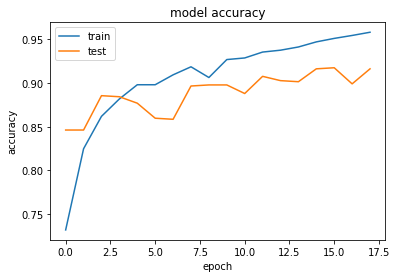

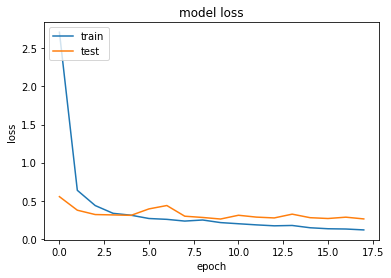

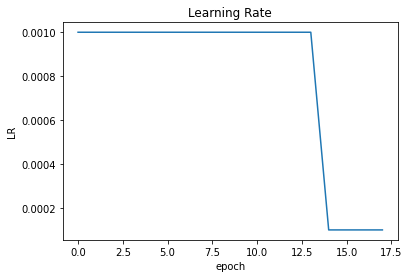

In [39]:
# Plot the history keys of the trained model


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Learning rate
plt.plot(history.history['lr'])
plt.title('Learning Rate')
plt.ylabel('LR')
plt.xlabel('epoch')
plt.show()

In [38]:
# Re-instantiate the hypermodel and train it with the optimal number of epochs from above on the ENTIRE DATA

hypermodel = tuner.hypermodel.build(best_hps)


# Building the Data Generator again without validation split

generator = ImageDataGenerator(rotation_range=10, 
                               brightness_range=(0.5, 1.5), 
                               horizontal_flip=True,
                               preprocessing_function=preprocess_input                               
                              )

iterator = generator.flow_from_directory(face_crops_dir, 
                                        target_size=image_size,                                        
                                        batch_size=32
                                        )


# Retrain the model
hypermodel.fit(iterator,
               epochs=best_epoch
               )

Found 4072 images belonging to 3 classes.
Epoch 1/16
128/128 [==============================] - 48s 359ms/step - loss: 1.8877 - accuracy: 0.7588
Epoch 2/16
128/128 [==============================] - 46s 362ms/step - loss: 0.5299 - accuracy: 0.8291
Epoch 3/16
128/128 [==============================] - 46s 358ms/step - loss: 0.4086 - accuracy: 0.8649
Epoch 4/16
128/128 [==============================] - 46s 359ms/step - loss: 0.3446 - accuracy: 0.8856
Epoch 5/16
128/128 [==============================] - 46s 357ms/step - loss: 0.3129 - accuracy: 0.8878
Epoch 6/16
128/128 [==============================] - 46s 358ms/step - loss: 0.2908 - accuracy: 0.8971
Epoch 7/16
128/128 [==============================] - 46s 358ms/step - loss: 0.2750 - accuracy: 0.8993
Epoch 8/16
128/128 [==============================] - 46s 359ms/step - loss: 0.2413 - accuracy: 0.9106
Epoch 9/16
128/128 [==============================] - 46s 358ms/step - loss: 0.2374 - accuracy: 0.9113
Epoch 10/16
128/128 [==========

In [42]:
# Saving the model

hypermodel.save('SavedModel')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: SavedModel/assets


In [43]:
# Saving the model weights for inference

hypermodel.save_weights("ckpt")

In [44]:
# HDF5 Format

hypermodel.save_weights("hypermodel_weights.h5")

In [ ]:
# Inference

def infer():
    face_detector = cv2.CascadeClassifier('haarcascade.xml')
    vid = cv2.VideoCapture(0)

    while(True):
        _, frame = vid.read()
        grey = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_detector.detectMultiScale(grey, 1.1, 4)
        
        if faces != ():
            for (x,y,w,h) in faces:
                crop = preprocess_input(frame[y:y+h, x:x+w])
                crop = cv2.resize(crop, (224,224))
                crop = crop.reshape(1,224,224,3)
                prediction = model.predict(crop)
                arg_pred = np.argmax(prediction[0])
                if arg_pred == 1: # No Mask (Box in RED Color)
                    cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255), 1)
                elif arg_pred == 0: # With Mask (Box in GREEN Color)
                    cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0), 1)
                else: # Improper Mask   (Box in BLUE Color)
                    cv2.rectangle(frame, (x,y), (x+w, y+h), (255,0,0), 1)


        cv2.imshow('Frame', frame)

        k = cv2.waitKey(30) & 0xff
        if k==27:
            break
    vid.release()
    cv2.destroyAllWindows()

In [ ]:
infer()